# 컴퓨터 비전 학습 경진대회, Dacon.io
### https://dacon.io/competitions/official/235626/overview/

6가지의 모델을 Ensemble하여 사용하였습니다. <br>

모델: thin_resnet, xception, inception, densenet, vggnet, resnet <br>
thin_resnet은 resnet기반으로 만든 조금 작은 모델입니다. <br>
나머지 모델들은 keras(tensorflow)의 application을 그대로 사용하였습니다. <br>

train dataset으로 학습을 시키고 test dataset을 predict한 결과 중 일정 점수 이상을
받은 데이터들을 train dataset에 추가하여 다시 학습하였습니다.

Ensemble은 여러 모델의 각 fold로 예측한 값의 root sum을 사용하였고, <br>
Loss는 mse, optimizer는 adam을 사용하였습니다. <br>

Data Augmentation은 keras의 RandomRotation과 직접 구현한 RandomRoll을 사용하였습니다.
keras의 RandomTranslation은 성능이 좋지 않아 사용하지 않았습니다.


In [ ]:
!nvidia-smi

Thu May  6 09:52:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:05.0 Off |                  Off |
| N/A   50C    P0    68W / 300W |  17548MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:00:06.0 Off |                  Off |
| N/A   

In [2]:
!pip install tensorflow_addons

     |████████████████████████████████| 686kB 13.9MB/s 


In [3]:
import os
import time
import glob
import shutil
import gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from albumentations import Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip, Rotate, RandomCrop, RandomBrightnessContrast

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D, Permute
from tensorflow.keras.layers import MaxPooling1D, Dropout, Reshape, Multiply, Conv2D, MaxPool2D, LSTM, Add, Lambda, AveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D, LeakyReLU, PReLU, GlobalAveragePooling2D, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomTranslation, RandomRotation, RandomZoom
from tensorflow_addons.layers.netvlad import NetVLAD
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier 
from tensorflow.keras.applications import ResNet50, ResNet152
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import EfficientNetB7, EfficientNetB4, EfficientNetB2, EfficientNetB1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
train_csv = pd.read_csv('/content/drive/MyDrive/DACON_Computer Vision Learning Contest/data/train.csv')
test_csv = pd.read_csv('/content/drive/MyDrive/DACON_Computer Vision Learning Contest/data/test.csv')
submission_csv = pd.read_csv('submission.csv')

In [6]:
train_csv

,id,digit,letter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,4,4,3,0,4,3,3,3,4,4,0,0,1,1,3,4,0,4,2,0,4,0,1,3,1,0,4,1,1,3,...,4,3,4,1,3,0,0,1,3,3,3,0,3,2,2,1,0,1,0,0,3,0,0,4,2,0,3,4,1,1,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,1,4,2,0,3,4,0,0,2,3,4,0,3,4,3,0,2,2,1,4,2,3,3,4,1,2,4,2,0,3,...,4,2,3,0,0,0,0,4,3,2,2,4,2,1,1,1,3,3,1,2,4,4,4,2,2,4,4,0,4,2,0,3,0,1,4,1,4,2,1,2
2,3,4,L,1,1,2,2,1,1,1,0,2,1,3,2,2,2,4,1,1,4,1,0,1,3,4,2,2,2,4,1,1,2,0,3,0,2,3,4,0,...,3,0,4,0,3,0,2,0,1,4,2,3,4,4,4,0,2,0,4,4,1,3,0,3,2,0,2,3,0,2,3,3,3,0,2,0,3,0,2,2
3,4,9,D,1,2,0,2,0,4,0,3,4,3,1,0,3,2,2,0,3,4,1,0,4,1,2,2,3,2,2,0,2,0,3,0,3,2,4,0,0,...,0,3,0,1,4,1,3,1,2,1,1,1,2,2,2,4,3,4,3,0,4,1,2,4,1,4,0,1,0,4,3,3,2,0,1,4,0,0,1,1
4,5,6,A,3,0,2,4,0,3,0,4,2,4,2,1,4,1,1,4,4,0,2,3,4,4,3,3,3,3,4,1,0,3,0,3,0,0,0,1,1,...,2,1,3,2,1,4,2,3,2,2,1,0,4,2,2,1,2,1,0,3,2,2,2,2,1,4,2,1,2,1,4,4,3,2,1,3,4,3,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,2044,6,V,2,4,3,4,2,4,4,1,2,1,3,3,4,4,3,4,1,0,4,4,4,1,1,1,2,3,4,1,2,3,3,2,3,1,3,4,0,...,2,4,1,1,1,1,2,3,1,2,0,2,4,1,0,3,4,4,0,1,3,3,3,3,2,0,3,3,3,2,0,2,2,0,0,1,3,1,4,0
2044,2045,1,L,3,2,2,1,1,4,0,1,4,2,0,3,3,2,2,1,2,3,2,2,4,1,0,4,1,0,2,0,3,0,2,3,3,3,4,0,4,...,0,1,1,1,1,3,0,4,2,0,4,3,1,4,0,1,0,0,3,3,0,0,1,3,3,1,2,0,3,2,2,3,4,2,1,2,3,4,1,1
2045,2046,9,A,4,0,4,0,2,4,4,4,3,4,0,1,3,4,1,0,2,2,0,0,3,3,2,0,4,3,2,3,4,3,1,1,4,4,4,1,1,...,3,2,4,3,2,1,1,0,4,0,4,4,1,3,3,1,3,4,1,0,2,4,1,2,4,4,4,3,4,2,2,3,1,1,3,4,2,2,0,0
2046,2047,0,Z,2,3,3,0,3,0,4,3,0,1,4,0,0,0,2,3,1,1,1,0,2,4,1,0,3,0,1,2,4,1,4,3,1,4,4,4,0,...,0,0,2,0,2,3,2,0,3,0,1,0,1,0,1,2,3,2,1,1,0,0,3,1,4,1,1,2,1,3,2,3,1,1,0,4,1,4,3,1


In [7]:
label_encoder = LabelEncoder()

# TRAIN
train_letters_char = train_csv['letter'].values
train_letters_int = label_encoder.fit_transform(train_letters_char)
train_letters = keras.utils.to_categorical(train_letters_int)

train_pixels = train_csv.loc[:, '0':'783'].values
train_pixels = train_pixels.astype(np.float32)
train_pixels = train_pixels.reshape((-1, 28, 28, 1))

train_digits_int = train_csv['digit'].values
train_digits = keras.utils.to_categorical(train_digits_int)

# TEST
test_letters_char = test_csv['letter'].values
test_letters_int = label_encoder.fit_transform(test_letters_char)
test_letters = keras.utils.to_categorical(test_letters_int)

test_pixels = test_csv.loc[:, '0':'783'].values
test_pixels = test_pixels.astype(np.float32)
test_pixels = test_pixels.reshape((-1, 28, 28, 1))

print(train_letters.shape, train_letters.dtype)
print(train_digits.shape, train_digits.dtype)
print(train_pixels.shape, train_pixels.dtype)

print(test_letters.shape, test_letters.dtype)
print(test_pixels.shape, test_pixels.dtype)

(2048, 26) float32
(2048, 10) float32
(2048, 28, 28, 1) float32
(20480, 26) float32
(20480, 28, 28, 1) float32


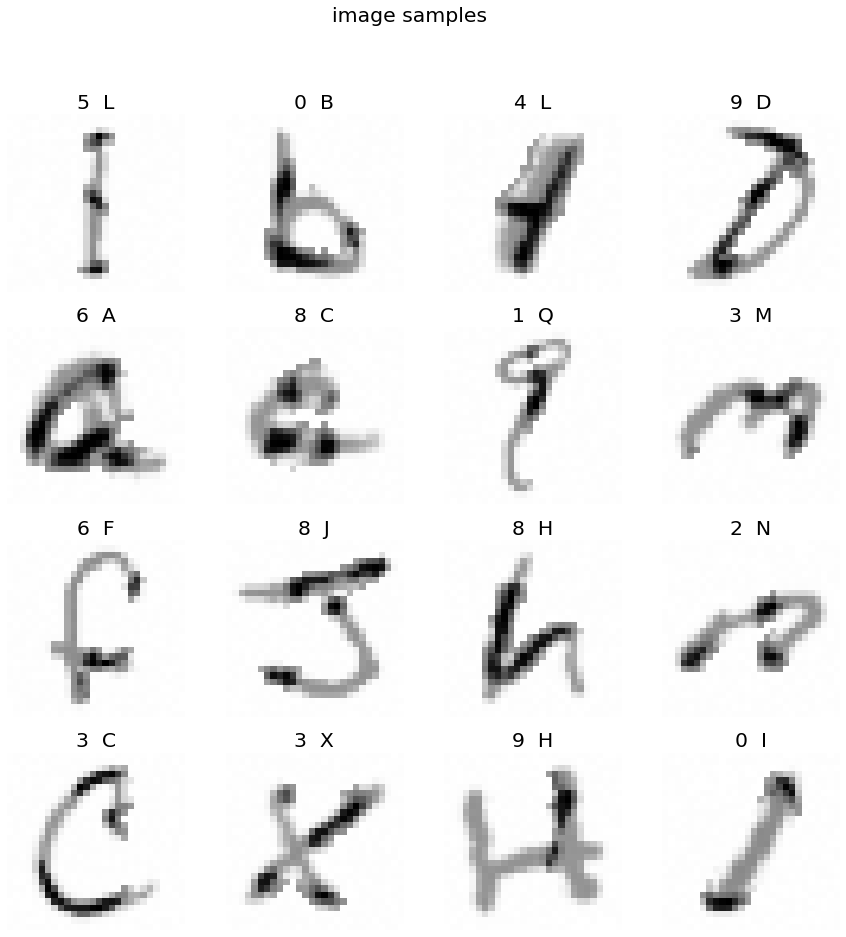

In [8]:
plt.rcParams.update({'font.size': 17})
fig, axs = plt.subplots(4, 4)
fig.suptitle('image samples')
fig.set_size_inches(15, 15)

# train_pixels[train_pixels < 0.6] = 0

for i in range(len(axs)):
    for j in range(len(axs[i])):
        img = train_pixels[i * 4 + j].reshape((28, 28))
        # img[img < 150] = 0.0
        # img[img >= 150] = 1.0
        axs[i][j].imshow(img, cmap='Greys')
        axs[i][j].axis('off')
        axs[i][j].title.set_text(f'{train_digits_int[i * 4 + j]}  {train_letters_char[i * 4 + j]}')
plt.show()


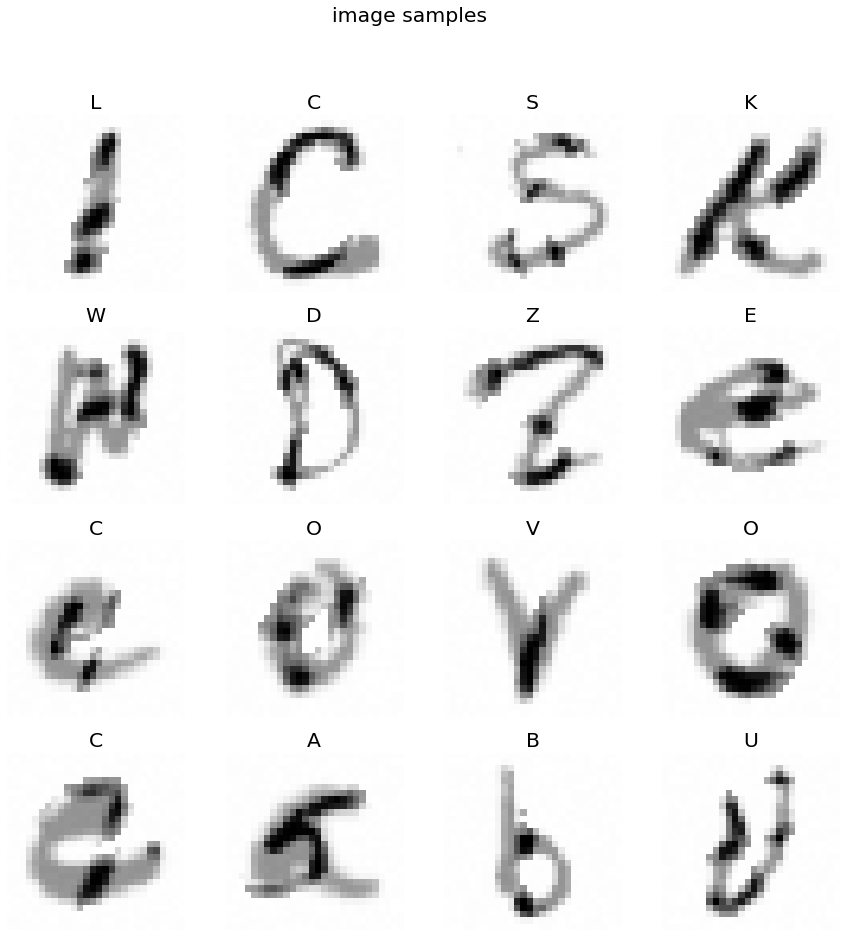

In [9]:
plt.rcParams.update({'font.size': 17})
fig, axs = plt.subplots(4, 4)
fig.suptitle('image samples')
fig.set_size_inches(15, 15)

# train_pixels[train_pixels < 0.6] = 0

for i in range(len(axs)):
    for j in range(len(axs[i])):
        img = test_pixels[i * 4 + j].reshape((28, 28))
        # img[img < 150] = 0
        # img[img >= 150] = 1
        axs[i][j].imshow(img, cmap='Greys')
        axs[i][j].axis('off')
        axs[i][j].title.set_text(f'{test_letters_char[i * 4 + j]}')
plt.show()


In [10]:
input_shape_1 = train_letters.shape[1:]
input_shape_2 = train_pixels.shape[1:]
output_size = train_digits.shape[1]

print(input_shape_1)
print(input_shape_2)
print(output_size)

(26,)
(28, 28, 1)
10


In [11]:
class RandomRollLayer(tf.keras.layers.Layer):
    """Shift data"""

    def __init__(self, roll_limit=0.1, u=0.5, **kwargs):
        super().__init__(**kwargs)
        self.roll_limit = roll_limit
        self.u = u

    def build(self, input_shape):
        self.non_trainable_weights.append(self.roll_limit)
        self.non_trainable_weights.append(self.u)
        super().build(input_shape)

    def call(self, pixels, training=None):
        if training is None:
            training = K.learning_phase()

        if not training:
            return pixels

        if tf.random.uniform(shape=[]) < self.u:
            roll_limit = self.roll_limit * pixels.shape[1]
            roll_limit = tf.cast(roll_limit, tf.int32)
            roll = tf.random.uniform(shape=[], minval=-roll_limit, maxval=roll_limit, dtype=tf.int32)

            pixels = tf.roll(pixels, shift=roll, axis=1)

        if tf.random.uniform(shape=[]) < self.u:
            roll_limit = self.roll_limit * pixels.shape[2]
            roll_limit = tf.cast(roll_limit, tf.int32)
            roll = tf.random.uniform(shape=[], minval=-roll_limit, maxval=roll_limit, dtype=tf.int32)

            pixels = tf.roll(pixels, shift=roll, axis=2)
            
        return pixels

    def get_config(self):
        config = {
            'roll_limit': self.roll_limit,
            'u': self.u,
        }
        config.update(super().get_config())

        return config

class RandomAddLayer(tf.keras.layers.Layer):
    """Add data"""

    def __init__(self, add_limit=0.1, u=0.5, **kwargs):
        super().__init__(**kwargs)
        self.add_limit = add_limit
        self.u = u

    def build(self, input_shape):
        self.non_trainable_weights.append(self.add_limit)
        self.non_trainable_weights.append(self.u)
        super().build(input_shape)

    def call(self, pixels, training=None):
        if training is None:
            training = K.learning_phase()

        if not training:
            return pixels

        if tf.random.uniform(shape=[]) < self.u:
            add = tf.random.uniform(shape=[], minval=-self.add_limit, maxval=self.add_limit, dtype=tf.float32)
            pixels = pixels + add

        return pixels

    def get_config(self):
        config = {
            'add_limit': self.add_limit,
            'u': self.u,
        }
        config.update(super().get_config())

        return config

class RandomMultipleLayer(tf.keras.layers.Layer):
    """Multiple data"""

    def __init__(self, multiple_limit=0.5, u=0.5, **kwargs):
        super().__init__(**kwargs)
        self.multiple_limit = multiple_limit
        self.u = u

    def build(self, input_shape):
        self.non_trainable_weights.append(self.multiple_limit)
        self.non_trainable_weights.append(self.u)
        super().build(input_shape)

    def call(self, pixels, training=None):
        if training is None:
            training = K.learning_phase()

        if not training:
            return pixels

        if tf.random.uniform(shape=[]) < self.u:
            multiple = tf.random.uniform(shape=[], minval=-self.multiple_limit, maxval=self.multiple_limit, dtype=tf.float32)
            pixels = pixels * (1 + multiple)

        return pixels
    
    def get_config(self):
        config = {
            'multiple_limit': self.multiple_limit,
            'u': self.u,
        }
        config.update(super().get_config())

        return config

In [12]:
def thin_resnet_model(input_shape_1, input_shape_2, output_size=10, num_clusters=10):
    input_1 = Input(shape=input_shape_1)  # letter
    input_2 = Input(shape=input_shape_2)  # pixel

    y = input_2
    y = Rescaling(scale=1.0/127.5, offset=-1.0)(y)
    y = RandomRollLayer(roll_limit=0.2, u=0.8)(y)
    y = RandomRotation(factor=(-0.1, 0.1), fill_mode='constant')(y)

    # y = RandomTranslation(0.1, 0.1)(y)
    # y = RandomRotation(0.1)(y)
    # y = RandomZoom(0.1)(y)

    # CONV 1
    y = Conv2D(64, (7, 7), padding='same')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = MaxPool2D((2, 2), strides=(2, 2))(y)

    # CONV 2 - 1
    y1 = Conv2D(48, (1, 1), padding='valid')(y)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(48, (3, 3), padding='same')(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(96, (1, 1), padding='valid')(y1)
    y1 = BatchNormalization()(y1)
    
    y2 = Conv2D(96, (1, 1), padding='valid')(y)
    y2 = BatchNormalization()(y2)
    y = Add()([y1, y2])
    y = Activation('relu')(y)

    # CONV 2 - 2
    y1 = Conv2D(48, (1, 1), padding='valid')(y)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(48, (3, 3), padding='same')(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(96, (1, 1), padding='valid')(y1)
    y1 = BatchNormalization()(y1)
    
    y = Add()([y1, y])
    y = Activation('relu')(y)


    # CONV 3 - 1
    y1 = Conv2D(96, (1, 1), padding='valid', strides=(2, 2))(y)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(96, (3, 3), padding='same')(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(128, (1, 1), padding='valid')(y1)
    y1 = BatchNormalization()(y1)

    y2 = AveragePooling2D((2, 2), strides=2, padding='same')(y)
    y2 = Conv2D(128, (1, 1), padding='valid')(y2)
    # y2 = Conv2D(128, (1, 1), padding='valid', strides=(2, 2))(y)
    y2 = BatchNormalization()(y2)
    y = Add()([y1, y2])
    y = Activation('relu')(y)
  
    # CONV 3 - 2
    y1 = Conv2D(96, (1, 1), padding='valid')(y)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(96, (3, 3), padding='same')(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(128, (1, 1), padding='valid')(y1)
    y1 = BatchNormalization()(y1)

    y = Add()([y1, y])
    y = Activation('relu')(y)

    # CONV 4 - 1
    y1 = Conv2D(128, (1, 1), padding='valid', strides=(2, 2))(y)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(128, (3, 3), padding='same')(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(256, (1, 1), padding='valid')(y1)
    y1 = BatchNormalization()(y1)

    # y2 = Conv2D(256, (1, 1), padding='valid', strides=(2, 2))(y)
    y2 = AveragePooling2D((2, 2), strides=2, padding='same')(y)
    y2 = Conv2D(256, (1, 1), padding='valid')(y2)
    y2 = BatchNormalization()(y2)
    y = Add()([y1, y2])
    y = Activation('relu')(y)

    # CONV 4 - 2
    y1 = Conv2D(128, (1, 1), padding='valid')(y)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(128, (3, 3), padding='same')(y1)
    y1 = BatchNormalization(gamma_initializer='zeros')(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(256, (1, 1), padding='valid')(y1)
    y1 = BatchNormalization()(y1)

    y = Add()([y1, y])
    y = Activation('relu')(y)

    # CONV 5 - 1
    y1 = Conv2D(256, (1, 1), padding='valid', strides=(2, 2))(y)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(256, (3, 3), padding='same')(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(512, (1, 1), padding='valid')(y1)
    y1 = BatchNormalization()(y1)

    # y2 = Conv2D(512, (1, 1), padding='valid', strides=(2, 2))(y)
    y2 = AveragePooling2D((2, 2), strides=2, padding='same')(y)
    y2 = Conv2D(512, (1, 1), padding='valid')(y2)
    y2 = BatchNormalization()(y2)
    y = Add()([y1, y2])
    y = Activation('relu')(y)

    # CONV 5 - 2
    y1 = Conv2D(256, (1, 1), padding='valid')(y)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(256, (3, 3), padding='same')(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = Conv2D(512, (1, 1), padding='valid')(y1)
    y1 = BatchNormalization()(y1)

    y = Add()([y1, y])
    y = Activation('relu')(y)

    # CONV 6
    y = Conv2D(512, (2, 2), padding='valid')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    # y = Reshape((-1, 512))(y)
    # y = Flatten()(y)
    y = GlobalAveragePooling2D()(y)
    # y = NetVLAD(num_clusters=num_clusters)(y)
    y = tf.keras.layers.Concatenate(axis=1)([y, input_1])
    y = Dropout(0.3)(y)

    y = Dense(output_size)(y)
    y = Activation('softmax')(y)
    output = y

    model = Model(inputs=[input_1, input_2], outputs=output, name='thin_resnet_model')
    # optimizer = tfa.optimizers.AdamW(learning_rate=0.05, weight_decay=0.0001)
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    

    return model

In [13]:
from tensorflow.keras.applications import VGG19


def vggnet_model(input_shape_1, input_shape_2, output_size=10):
    input_1 = Input(shape=input_shape_1)  # letter
    input_2 = Input(shape=input_shape_2)  # pixel

    y = input_2

    y = Rescaling(scale=1.0/127.5, offset=-1.0)(y)
    y = tf.keras.layers.experimental.preprocessing.Resizing(height=56, width=56)(y)
    y = RandomRollLayer(roll_limit=0.2, u=0.8)(y)
   

    model = VGG19(include_top=False, input_tensor=y, pooling='max', input_shape=y.shape[1:], weights=None)

    y = model.output
    y = Dense(1024)(y)
    y = Dropout(0.25)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = tf.keras.layers.Concatenate(axis=1)([y, input_1])
    y = Dense(256)(y)
    y = Dropout(0.25)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dense(output_size, activation='softmax', name='softmax')(y)

    output = y

    model = Model(inputs=[input_1, input_2], outputs=output, name='vggnet_model')
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

    return model
    

In [14]:
from tensorflow.keras.applications import ResNet101V2


def resnet_model(input_shape_1, input_shape_2, output_size=10):
    input_1 = Input(shape=input_shape_1)  # letter
    input_2 = Input(shape=input_shape_2)  # pixel

    y = input_2

    y = Rescaling(scale=1.0/127.5, offset=-1.0)(y)
    y = tf.keras.layers.experimental.preprocessing.Resizing(height=56, width=56)(y)
    y = RandomRollLayer(roll_limit=0.2, u=0.8)(y)
   

    model = ResNet101V2(include_top=False, input_tensor=y, pooling='max', input_shape=y.shape[1:], weights=None)

    y = model.output
    y = Dense(1024)(y)
    y = Dropout(0.25)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = tf.keras.layers.Concatenate(axis=1)([y, input_1])
    y = Dense(256)(y)
    y = Dropout(0.25)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dense(output_size, activation='softmax', name='softmax')(y)

    output = y

    model = Model(inputs=[input_1, input_2], outputs=output, name='resnet_model')
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

    return model
    

In [15]:
from tensorflow.keras.applications import DenseNet121


def densenet_model(input_shape_1, input_shape_2, output_size=10):
    input_1 = Input(shape=input_shape_1)  # letter
    input_2 = Input(shape=input_shape_2)  # pixel

    y = input_2

    y = Rescaling(scale=1.0/127.5, offset=-1.0)(y)
    y = tf.keras.layers.experimental.preprocessing.Resizing(height=112, width=112)(y)
    y = RandomRollLayer(roll_limit=0.2, u=0.8)(y)
    y = RandomRotation(factor=(-0.1, 0.1), fill_mode='constant')(y)

    model = DenseNet121(include_top=False, input_tensor=y, input_shape=y.shape[1:], weights=None, pooling='max')

    y = model.output
    y = Dense(1024)(y)
    y = Dropout(0.25)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = tf.keras.layers.Concatenate(axis=1)([y, input_1])
    y = Dense(256)(y)
    y = Dropout(0.25)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dense(output_size, activation='softmax', name='softmax')(y)
    output = y

    model = Model(inputs=[input_1, input_2], outputs=output, name='densenet_model')
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

    return model


In [16]:
from tensorflow.keras.applications import Xception


def xception_model(input_shape_1, input_shape_2, output_size=10):
    input_1 = Input(shape=input_shape_1)  # letter
    input_2 = Input(shape=input_shape_2)  # pixel

    y = input_2

    y = Rescaling(scale=1.0/127.5, offset=-1.0)(y)
    y = tf.keras.layers.experimental.preprocessing.Resizing(height=112, width=112)(y)
    y = RandomRollLayer(roll_limit=0.2, u=0.8)(y)
    y = RandomRotation(factor=(-0.1, 0.1), fill_mode='constant')(y)

    model = Xception(include_top=False, input_tensor=y, input_shape=y.shape[1:], weights=None, pooling='max')

    y = model.output
    y = Dense(1024)(y)
    y = Dropout(0.25)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = tf.keras.layers.Concatenate(axis=1)([y, input_1])
    y = Dense(256)(y)
    y = Dropout(0.25)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dense(output_size, activation='softmax', name='softmax')(y)
    output = y

    model = Model(inputs=[input_1, input_2], outputs=output, name='xception_model')
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

    return model


In [17]:
from tensorflow.keras.applications import InceptionV3


def inception_model(input_shape_1, input_shape_2, output_size=10):
    input_1 = Input(shape=input_shape_1)  # letter
    input_2 = Input(shape=input_shape_2)  # pixel

    y = input_2

    y = Rescaling(scale=1.0/127.5, offset=-1.0)(y)
    y = tf.keras.layers.experimental.preprocessing.Resizing(height=112, width=112)(y)
    y = RandomRollLayer(roll_limit=0.2, u=0.8)(y)
    y = RandomRotation(factor=(-0.1, 0.1), fill_mode='constant')(y)

    model = InceptionV3(include_top=False, input_tensor=y, input_shape=y.shape[1:], weights=None, pooling='max')

    y = model.output
    y = Dense(1024)(y)
    y = Dropout(0.25)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = tf.keras.layers.Concatenate(axis=1)([y, input_1])
    y = Dense(256)(y)
    y = Dropout(0.25)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dense(output_size, activation='softmax', name='softmax')(y)
    output = y

    model = Model(inputs=[input_1, input_2], outputs=output, name='inception_model')
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

    return model

In [20]:
def k_fold_validation(model_fn, n_splits=5, verbose=1):
    kf = KFold(n_splits=n_splits)
    sum_accuracy = 0
    sum_epoch = 0
    start_time = time.time()
    for i, (train_index, val_index) in enumerate(kf.split(train_digits)):
        model = model_fn(input_shape_1=input_shape_1, input_shape_2=input_shape_2, output_size=output_size)

        train_data = [train_letters[train_index], train_pixels[train_index]]
        train_label = train_digits[train_index]

        val_data = [train_letters[val_index], train_pixels[val_index]]
        val_label = train_digits[val_index]
        EPOCHS = 300
        history = model.fit(
            train_data, train_label,
            epochs=EPOCHS,
            validation_data=(val_data, val_label),
            batch_size=BATCH_SIZE,
            verbose=verbose,
            callbacks=[early_stopping],
        )

        sum_epoch += len(history.history['val_accuracy'])
        sum_accuracy += max(history.history['val_accuracy'])
        
        if verbose >= 0:            
            print(f'{i+1}/{n_splits} fold result: ')
            print('epoch num:', len(history.history['val_accuracy']))
            print('best val accuracy: ', max(history.history['val_accuracy']))
            print('average 20: ', np.mean(history.history['val_accuracy'][-20:]))
            print('='*50)

    print('Average Accuracy: ', sum_accuracy/n_splits)
    print('Average Epoch: ', sum_epoch/n_splits)
    print('Time taken: ', time.time() - start_time)
    print('='*50)

In [23]:
k_fold_validation(resnet_model, verbose=1)

NameError: ignored

## 실험 결과

### Augumentation
No Augumentation -> 0.69
RandomRollLayer(roll_limit=0.2, u=0.8)(y) -> 0.835
Roll + ResNet-D -> 0.824
RandomTranslation(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode='constant')(y) -> 0.768
RandomRotation(factor=(-0.2, 0.2), fill_mode='constant')(y) -> 0.731
RandomAddLayer(add_limit=0.1, u=0.8)(y) -> 0.751
RandomZoom(height_factor=(0, 0.2), width_factor=(0, 0.2), fill_mode='reflect')(y) -> 0.689

### Model
thin_resnet_model -> 0.835
xception_model -> 0.894
inception_model -> 0.886
densenet_model -> 0.885
vggnet_model -> 0.833
resnet_model -> 0.840

### Loss
RMSProp + categorical_crossentropy -> 0.823

### Batch size
smaller is better

In [22]:
model_fn_list = [
    thin_resnet_model,
    vggnet_model,
    resnet_model,
    densenet_model,
    xception_model,
    inception_model
]

EPOCHS = 300
BATCH_SIZE = 16
CHECKPOINT_PATH = 'checkpoint/'
MODEL_PATH = 'model/'

In [ ]:
if os.path.isdir(CHECKPOINT_PATH):
    shutil.rmtree(CHECKPOINT_PATH, ignore_errors=True)
os.mkdir(CHECKPOINT_PATH)

if os.path.isdir(MODEL_PATH):
    shutil.rmtree(MODEL_PATH, ignore_errors=True)
os.mkdir(MODEL_PATH)

In [ ]:
for model_fn in model_fn_list:
    kf = KFold(n_splits=5)
    for i, (train_index, val_index) in enumerate(kf.split(train_digits)):
        start_time = time.time()
        model = model_fn(input_shape_1=input_shape_1, input_shape_2=input_shape_2, output_size=output_size)

        # Validation 점수가 가장 좋은 모델만 저장합니다.
        checkpoint_path = os.path.join(CHECKPOINT_PATH, f'{model.name}_fold{i+1}')
        if os.path.isdir(checkpoint_path):
            shutil.rmtree(checkpoint_path, ignore_errors=True)
        os.mkdir(checkpoint_path)
        checkpoint_file_path = os.path.join(checkpoint_path, 'Epoch_{epoch:03d}_Val_{val_loss:.3f}.hdf5')
        checkpoint = ModelCheckpoint(filepath=checkpoint_file_path, monitor='val_accuracy', verbose=0, save_best_only=True)

        # 30회 간 Validation 점수가 좋아지지 않으면 중지합니다.
        early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)

        train_data = [train_letters[train_index], train_pixels[train_index]]
        train_label = train_digits[train_index]

        val_data = [train_letters[val_index], train_pixels[val_index]]
        val_label = train_digits[val_index]

        history = model.fit(
            train_data, train_label,
            epochs=EPOCHS,
            validation_data=(val_data, val_label),
            batch_size=BATCH_SIZE,
            verbose=1,
            callbacks=[early_stopping, checkpoint],
        )

        # 가장 좋은 모델의 weight를 불러옵니다.
        weigth_file = glob.glob('{}/*.hdf5'.format(checkpoint_path))[-1]
        model.load_weights(weigth_file)
        model.save(os.path.join(MODEL_PATH, f'{model.name}_{i+1}.h5'))
        
        shutil.rmtree(checkpoint_path, ignore_errors=True)

        epoch_num = len(history.history['val_accuracy'])
        max_accuracy = max(history.history['val_accuracy'])
        print('='*50)
        print(f'Result of {model.name}, fold {i+1}')
        print(f'Epoch: {epoch_num}')
        print(f'Accuracy: {max_accuracy}')
        print('Time taken: ', time.time() - start_time)
        print('='*50)



In [ ]:
import subprocess as sp
import os

def get_gpu_memory():
    total = 6144
    _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]

    ACCEPTABLE_AVAILABLE_MEMORY = 1024
    COMMAND = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = _output_to_list(sp.check_output(COMMAND.split()))[1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    print(f"Free: {memory_free_values[0]}MB / {total}MB    {(total - memory_free_values[0]) / total * 100:.2f}% used ")
    
def reset_keras():
    sess = tf.compat.v1.keras.backend.get_session()
    tf.compat.v1.keras.backend.clear_session()
    sess.close()
    sess = tf.compat.v1.keras.backend.get_session()

    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

get_gpu_memory()

In [ ]:
model_files = glob.glob(f'{MODEL_PATH}/*.h5')
pred_list = []
for i, model_file in enumerate(model_files):
    model = keras.models.load_model(model_file,
                                    custom_objects={'RandomRollLayer':RandomRollLayer})

    print(i+1, model.name)
    y_pred = model.predict([test_letters, test_pixels])
    pred_list.append(y_pred)
    model = None
    gc.collect()
    reset_keras()
    get_gpu_memory()
    print('='*50)

In [ ]:
ensemble_data = np.zeros(pred_list[0].shape)

for pred in pred_list:
    ensemble_data += pred ** 0.5
    
y_pred = np.argmax(ensemble_data, axis=1)

submission_csv['digit'] = y_pred
submission_csv.to_csv('CNN.csv', index=False)
submission_csv

In [ ]:
df = pd.DataFrame(ensemble_data)
df['max'] = df.iloc[:, 0:10].max(axis=1)
df['pred'] = df.iloc[:, 0:10].idxmax(axis=1)

good_df = df[df['max'] > 20]

test_digits_int = good_df['pred'].to_numpy()
test_digits = tf.keras.utils.to_categorical(test_digits_int)

new_digits = np.concatenate((train_digits, test_digits))
new_letters = np.concatenate((train_letters, test_letters[good_df.index]))
new_pixels = np.concatenate((train_pixels, test_pixels[good_df.index]))
new_digits.shape, new_letters.shape, new_pixels.shape

In [ ]:
train_digits = new_digits
train_letters = new_letters
train_pixels = new_pixels

In [ ]:
test_digits

In [ ]:
y_pred = np.argmax(model.predict([test_letters, test_pixels]), axis=1)
y_pred.shape

In [ ]:
submission_csv['digit'] = y_pred
submission_csv.to_csv('CNN.csv', index=False)
submission_csv